In [ ]:
# default_exp funcs.train_funcs

In [ ]:
%load_ext autoreload
%autoreload 2

# Training loop simulator learning

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def eval_logger(pred_df, target_df, iteration, data_str='Sim. '):
    
    perf_dict,_,shift = matching(target_df, pred_df, print_res=False)
    if 'Inp' in data_str:
        pred_corr = shift_df(pred_df, shift)
        perf_dict, _, _ = matching(target_df, pred_corr, print_res=False)

    wandb.log({data_str +'Metrics/eff_3d': perf_dict['eff_3d']}, step=iteration)
    wandb.log({data_str +'Metrics/jaccard': perf_dict['jaccard']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_vol': perf_dict['rmse_vol']}, step=iteration)

    wandb.log({data_str +'Metrics/precision': perf_dict['precision']}, step=iteration)
    wandb.log({data_str +'Metrics/recall': perf_dict['recall']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_x': perf_dict['rmse_x']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_y': perf_dict['rmse_y']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_z': perf_dict['rmse_z']}, step=iteration)   
    
def load_from_eval_dict(eval_dict):
    
    eval_img = load_tiff_image(sorted(glob.glob(eval_dict['image_path']))[eval_dict['img_ind']])[eval_dict['sm_fish_ch']][None]
    eval_img = eval_img[eval_dict['crop_sl']]
    eval_df = None
    eval_psf = None
    if eval_dict['txt_path'] is not None:
        txt_path = sorted(glob.glob(eval_dict['txt_path']))[eval_dict['img_ind']]
        eval_df = simfish_to_df(txt_path)
        eval_df = crop_df(eval_df, eval_dict['crop_sl'], px_size_zyx=eval_dict['px_size_zyx'])

    if eval_dict['psf_path'] is not None:
        eval_psf = load_tiff_image(eval_dict['psf_path'])
        
    return eval_img, eval_df, eval_psf

def save_train_state(save_dir, model, microscope, optim_dict, train_iter):
    
        torch.save({'state_dict':model.state_dict(), 'scaling':[model.inp_scale, model.inp_offset]}, save_dir/'model.pkl')
        torch.save(microscope.state_dict(), save_dir/'microscope.pkl')
        
        save_dict = {k:v.state_dict() for (k,v) in optim_dict.items()}
        save_dict['train_iter'] = train_iter
        
        torch.save(save_dict, save_dir/'training_state.pkl')

In [ ]:
#export
def train(cfg,
          model, 
          microscope,
          post_proc,
          dl, 
          optim_dict,
          eval_dict=None):
    
    """
    Training loop for autoencoder learning. Alternates between a simulator training step to train the inference network
    and an autoencoder step to train the PSF (and microscope) parameters.
    
    Args:
        model (torch.nn.Module): DECODE 3D UNet.
        dl  (torch.utils.data.dataloader.DataLoader): Dataloader that returns a random sub volume from the real volume, an estiamted emitter density and background.
        optim_net  (torch.optim.Optimizer): Optimizer for the network parameters.
        optim_mic  (torch.optim.Optimizer): Optimizer for the PSF parameters.
        sched_net  (torch.optim.lr_scheduler): LR scheduler for the network parameters.
        sched_mic  (torch.optim.lr_scheduler): LR scheduler for the PSF parameters.
        microscope (torch.nn.Module): Microscope class that transforms emitter locations into simulated images.
        eval_dict  (dict, optional): Dictionary with evaluation parameters
        
    """ 
    
    save_dir = Path(cfg.output.save_dir)
    
    if eval_dict is not None:
        eval_img, eval_df, eval_psf = load_from_eval_dict(eval_dict)

    model.cuda().train()
    torch.save(microscope.psf.state_dict(), str(save_dir) + '/psf_init.pkl' )

    for batch_idx in range(cfg.training.start_iter, cfg.training.num_iters):

        x, local_rate, background = next(iter(dl))
        
        optim_dict['optim_net'].zero_grad()
        
        sim_vars = PointProcessUniform(local_rate, int_conc=model.int_dist.int_conc.detach(), int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), sim_iters=5).sample()  
        # sim_vars = locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape
        xsim = microscope(*sim_vars)
        xsim_noise = microscope.noise(xsim, background).sample()

        out_sim = model.tensor_to_dict(model(xsim_noise))

        count_prob, spatial_prob = PointProcessGaussian(**out_sim).log_prob(*sim_vars[:5])
        gmm_loss = -(spatial_prob + cfg.training.net.cnt_loss_scale*count_prob).mean()
        
        background_loss = F.mse_loss(out_sim['background'], background) * cfg.training.net.bl_loss_scale

        loss = gmm_loss + background_loss
        
        # Update network parameters
        loss.backward()
        
#         if cfg.training.net.grad_clip: torch.nn.utils.clip_grad_norm_(model.unet.parameters(), max_norm=cfg.training.net.grad_clip, norm_type=2)
        if cfg.training.net.grad_clip: torch.nn.utils.clip_grad_norm_(model.network.parameters(), max_norm=cfg.training.net.grad_clip, norm_type=2)

        optim_dict['optim_net'].step()
        optim_dict['sched_net'].step()
        
#         optim_dict['optim_net'].zero_grad()
            
        if batch_idx > min(cfg.training.start_mic,cfg.training.start_int):
            
            out_inp = model.tensor_to_dict(model(x))
            proc_out_inp = post_proc.get_micro_inp(out_inp) # locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, comb_sig
            
            if cfg.training.mic.enabled and batch_idx > cfg.training.start_mic:
                
                optim_dict['optim_mic'].zero_grad()

                # Get autoencoder loss
                ae_img = microscope(*proc_out_inp[:6])
                log_p_x_given_z = -microscope.noise(ae_img,out_inp['background']).log_prob(x).mean()
                if cfg.training.mic.norm_reg:
                    log_p_x_given_z += cfg.training.mic.norm_reg * (microscope.psf.com_loss())

                log_p_x_given_z.backward()
                if cfg.training.mic.grad_clip:
                    torch.nn.utils.clip_grad_norm_(microscope.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)
                
                optim_dict['optim_mic'].step()
                optim_dict['sched_mic'].step()
            
            if  cfg.training.int.enabled and batch_idx > cfg.training.start_int and len(proc_out_inp[4]):
                
                optim_dict['optim_int'].zero_grad()
                ints = proc_out_inp[4]
                ints = torch.clamp_min(ints, model.int_dist.int_loc.detach() + 0.01)

                gamma_int = D.Gamma(model.int_dist.int_conc, model.int_dist.int_rate)
                loc_trafo = [D.AffineTransform(loc=model.int_dist.int_loc, scale=1)]
                int_loss = -D.TransformedDistribution(gamma_int, loc_trafo).log_prob(ints.detach()).mean()
                
                if cfg.training.int.grad_clip:
                    torch.nn.utils.clip_grad_norm_(model.int_dist.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)
                
                int_loss.backward()
                optim_dict['optim_int'].step()
                optim_dict['sched_int'].step()

        # Logging
        if batch_idx % 10 == 0:
            wandb.log({'SL Losses/gmm_loss': gmm_loss.detach().cpu()}, step=batch_idx)
            wandb.log({'SL Losses/count_loss': (-count_prob.mean()).detach().cpu()}, step=batch_idx)
            wandb.log({'SL Losses/bg_loss': background_loss.detach().cpu()}, step=batch_idx)
            wandb.log({'AE Losses/int_mu': model.int_dist.int_conc.item()/model.int_dist.int_rate.item() + model.int_dist.int_loc.item()}, step=batch_idx)
            wandb.log({'AE Losses/int_rate': model.int_dist.int_rate.item()}, step=batch_idx)
            wandb.log({'AE Losses/int_loc': model.int_dist.int_loc.item()}, step=batch_idx)
            wandb.log({'AE Losses/theta': microscope.noise.theta_par.item()*microscope.noise.theta_scale}, step=batch_idx)

            if batch_idx > cfg.training.start_mic: 
                if cfg.training.mic.enabled:
                    wandb.log({'AE Losses/p_x_given_z': log_p_x_given_z.detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/RMSE(rec)': torch.sqrt(((x-(ae_img+out_inp['background']))**2).mean()).detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/sum(psf)': F.relu(microscope.psf.psf_volume/microscope.psf.psf_volume.max())[0].sum().detach().cpu()}, step=batch_idx)
#                     wandb.log({'AE Losses/theta': microscope.theta.item()}, step=batch_idx)
        
        if batch_idx % cfg.output.log_interval == 0:
            print(batch_idx)
            with torch.no_grad():
                pred_df = post_proc.get_df(out_sim)
                px_size = cfg.evaluation.px_size_zyx
                target_df = sample_to_df(*sim_vars[:5], px_size_zyx=px_size)
                eval_logger(pred_df, target_df, batch_idx, data_str='Sim. ')
                
                wandb.log({'Sim. Metrics/prob_fac': torch.sigmoid(out_sim['logits']).sum().item()/(len(target_df)+0.1)}, step=batch_idx)
                wandb.log({'Sim. Metrics/n_em_fac': len(pred_df)/len(target_df)}, step=batch_idx)
#                 wandb.log({'Prob hist': wandb.Image(plot_prob_hist(out_sim))}, step=batch_idx)

                if cfg.output.log_figs:
                    sl_fig = sl_plot(x, xsim_noise, nm_to_px(pred_df, px_size), nm_to_px(target_df, px_size), background, out_sim)
                    plt.show()
                    wandb.log({'SL summary': sl_fig}, step=batch_idx)

                if eval_dict is not None:
                    res_eval = model.tensor_to_dict(model(eval_img[None].cuda()))
                    ae_img = microscope(*post_proc.get_micro_inp(res_eval)[:6])
                    pred_eval_df = post_proc.get_df(res_eval)
                    wandb.log({'AE Losses/N preds(eval)': len(pred_eval_df)}, step=batch_idx)
                    
                    if eval_df is not None:
                        eval_logger(pred_eval_df, eval_df, batch_idx, data_str='Inp. ')
                        
                    if eval_psf is not None:
                        wandb.log({'AE Losses/Corr(psf)': np.corrcoef(cpu(eval_psf).reshape(-1), cpu(microscope.psf.psf_volume).reshape(-1))[0,1]}, step=batch_idx)
                        wandb.log({'AE Losses/RMSE(psf)': np.sqrt(np.mean((cpu(eval_psf/eval_psf.max())-cpu(microscope.psf.psf_volume/microscope.psf.psf_volume.max()))**2))}, step=batch_idx)
        
                    if cfg.output.log_figs:
                        eval_fig = gt_plot(eval_img, nm_to_px(pred_eval_df, px_size), nm_to_px(eval_df, px_size), px_size,ae_img[0]+res_eval['background'][0], microscope.psf)
                        plt.show()
                        wandb.log({'GT': eval_fig}, step=batch_idx)

            # storing
            save_train_state(save_dir, model, microscope, optim_dict, batch_idx) 
            
    wandb.finish()

In [ ]:
cfg = OmegaConf.load('../config/experiment/MERFISH_starfish_ch0_f2.yaml')
cfg.run_name = 'test'

cfg.training.bs = 2

psf, noise, micro = load_psf_noise_micro(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes


In [ ]:
inp_offset, inp_scale = get_forward_scaling(img_3d[0])
model = hydra.utils.instantiate(cfg.model, inp_scale=float(inp_scale), inp_offset=float(inp_offset))

psf  .to('cuda')
model.to('cuda')
micro.to('cuda')

Microscope(
  (psf): LinearInterpolatedPSF(
    (forward_nonlin): Identity()
  )
  (noise): sCMOS()
)

In [ ]:
optim_dict = {}
optim_dict['optim_net'] = hydra.utils.instantiate(cfg.training.net.opt, params=model.parameters())
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters())
optim_dict['optim_int'] = hydra.utils.instantiate(cfg.training.int.opt, params=model.int_dist.parameters())

optim_dict['sched_net'] = hydra.utils.instantiate(cfg.training.net.sched, optimizer=optim_dict['optim_net'])
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])
optim_dict['sched_int'] = hydra.utils.instantiate(cfg.training.int.sched, optimizer=optim_dict['optim_int'])

if cfg.evaluation is not None:
    eval_dict = dict(cfg.evaluation)
    eval_dict['crop_sl'] = eval(eval_dict['crop_sl'],{'__builtins__': None},{'s_': np.s_})
    eval_dict['px_size_zyx'] = list(eval_dict['px_size_zyx'])
else:
    eval_dict = None
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
# Resume training from a previous checkpoint

# cfg.data_path.model_init = cfg.output.save_dir
if cfg.data_path.model_init is not None:
    print('loading')
    model = load_model_state(model, Path(cfg.data_path.model_init)/'model.pkl').cuda()
    micro.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'microscope.pkl'))
    
    train_state_dict = torch.load(Path(cfg.data_path.model_init)/'training_state.pkl')
    for k in optim_dict:
        optim_dict[k].load_state_dict(train_state_dict[k])
        
    cfg.training.start_iter = train_state_dict['train_iter']

In [ ]:
# point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48]).cuda()*.0001, min_int = 0.5, sim_iters=5)
# locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

In [ ]:
# xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
# plot_3d_projections(xsim[0,0])

In [ ]:
# _ = wandb.init(project=cfg.output.project, 
#                config=OmegaConf.to_container(cfg, resolve=True),
#                dir=cfg.output.log_dir,
#                group=cfg.output.group,
#                name=cfg.run_name,
#                mode='online'
#           )

tensor([3.8196, 4.0544, 3.8085, 3.6346, 4.2595, 3.4481, 3.7574, 3.6309, 3.2392,
        3.9260, 3.4959, 4.0021, 4.3969, 3.8269, 5.6008, 3.0750, 4.6484, 3.7822,
        3.2423, 5.0206, 4.0847, 4.5005, 4.0603, 3.4476, 4.0159, 3.9723, 3.5819,
        3.6154, 3.6110, 3.4109, 3.6370, 3.8170, 3.6245, 3.7361, 4.6738, 4.2668,
        3.9824, 4.4067, 4.2381, 3.2964, 3.4809, 4.2914, 4.0220, 3.2232, 3.5816,
        3.7406, 4.5504, 3.2865, 3.4844, 4.0404, 3.5802, 4.4336, 4.5097, 3.6566,
        3.9107, 4.5781, 5.0919, 4.8462, 4.6060, 4.6362, 5.6473, 3.3374, 4.4045,
        3.9017, 3.7170, 3.3528, 4.4257, 3.5826, 3.8854, 4.1021, 4.3285, 3.5828,
        5.0364, 3.3672, 4.8278, 4.2011, 3.2007, 3.4709, 3.4868, 4.3587, 3.9283,
        3.9745, 3.7610, 4.6576, 4.6462, 5.0082, 4.3612, 4.9212, 4.5593, 3.3879,
        4.0521, 3.2624, 3.8222, 4.6458, 4.2453, 3.3217, 3.7084, 3.6897, 3.2725,
        3.2544, 3.9107, 3.6199, 4.1353, 3.4935], device='cuda:0')
0


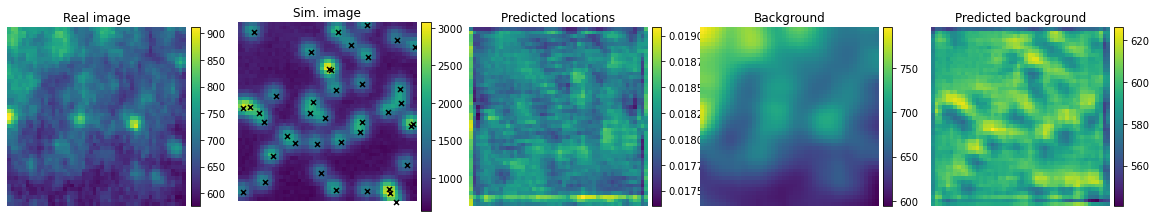

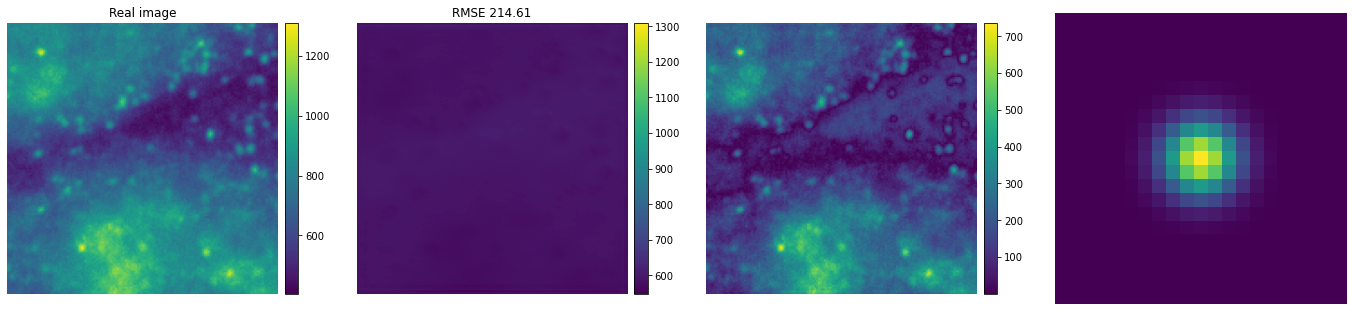

tensor([3.7969, 3.6794, 3.4071, 5.3976, 3.2231, 3.7370, 3.9253, 4.8837, 4.0582,
        3.6240, 4.3860, 4.7071, 3.4091, 3.8230, 3.6543, 4.5234, 3.2993, 4.4370,
        3.4957, 3.7111, 4.2697, 4.0239, 5.4737, 3.6400, 5.7492, 4.6640, 3.7660,
        5.3472, 3.4414, 4.1267, 3.5885, 4.5254, 4.0922, 3.4900, 4.8703, 3.8413,
        3.5485, 3.1779, 5.8929, 3.9408, 3.7105, 3.8201, 3.7317, 3.2218, 4.4868,
        3.7410, 3.6867, 3.9619, 4.4879, 3.5675], device='cuda:0')
tensor([4.8658, 3.7043, 4.8071, 4.2963, 3.7196, 3.5988, 3.5073, 3.3768, 4.4145,
        4.3343, 3.6948, 3.3510, 3.9480, 3.9503, 3.5505, 4.2562, 4.4219, 4.4116,
        3.1448, 3.6387, 3.6674, 4.9628, 3.8263, 3.8608, 4.1690, 4.9756, 4.0926,
        3.4255, 4.4668, 4.2915, 3.2939, 3.5360, 3.2726, 3.4641, 4.3261, 3.9835,
        4.0776, 3.7654, 4.0597, 4.0386, 5.6772, 4.4646, 3.4342, 3.3708, 3.5936,
        3.3089, 3.9587, 4.0978, 3.7073, 3.5949, 3.9847, 3.6849, 3.2160, 5.0024,
        3.8217, 4.8241, 3.4896, 4.1662, 4.0858, 3.8623

wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory


tensor([3.8244, 3.8201, 4.9015, 4.9107, 4.5412, 3.4541, 4.0631, 3.9304, 4.1633,
        4.3136, 3.6510, 3.7906, 3.9994, 3.8244, 4.9042, 6.7158, 4.3009, 4.4413,
        3.5201, 3.7685, 3.5437, 3.4084, 4.4577, 3.1125, 4.1594, 4.3176, 3.6337,
        3.3758, 5.0176, 3.8606, 3.7828, 4.7381, 3.4315, 3.5680, 3.7339, 3.6670,
        5.0137, 4.2400, 4.0603, 4.0768, 3.6678, 5.0540, 3.5247, 3.7502, 4.5254,
        3.8732, 3.5684, 4.2199, 4.3852, 3.9363, 5.4834, 4.2478, 3.4834, 3.9258,
        4.8014, 4.1725, 4.3037, 3.6601, 4.6003, 3.1363, 4.3768, 3.5873, 3.6123,
        3.3568, 4.6502, 3.4453, 3.4935, 3.4617, 4.1667, 4.2572, 3.4942, 3.7032,
        3.7345, 3.7199, 3.2674, 3.3697, 3.8786, 3.3487, 3.4647],
       device='cuda:0')
tensor([4.2858, 3.7442, 3.7845, 3.9798, 3.8673, 4.4274, 5.7734, 4.1879, 4.5159,
        3.4031, 3.7230, 3.8517, 4.4261, 3.3880, 3.8884, 3.4127, 3.7381, 3.8219,
        4.8370, 3.2361, 4.2704, 3.4992, 3.3341, 4.0298, 3.8739, 4.7231, 3.5475,
        4.1361, 3.2654, 4.2213,

tensor([3.5069, 3.8195, 3.8642, 3.6364, 5.0905, 4.0820, 3.8034, 3.5819, 3.8252,
        3.4186, 3.3084, 4.6140, 3.5625, 3.1740, 3.5364, 3.3438, 3.8515, 4.0884,
        3.7299, 4.0593, 3.2181, 5.3079, 3.2478, 3.4917, 5.3074, 4.1554, 4.1210,
        3.3697, 3.8337, 4.0013, 3.7289, 3.5212, 4.2272, 4.6215, 4.3627, 3.8542,
        3.2949, 3.5334, 3.4650, 3.9818, 4.3270, 3.7335, 3.9079, 3.2926, 4.2854,
        4.0049, 3.5007, 3.8487, 3.7488, 3.9131, 4.0477, 3.7123, 3.3506, 3.2588,
        3.8213, 4.0026, 3.5973, 4.3746, 4.6801, 3.6081, 4.2594, 3.5168, 3.8969,
        4.1377, 4.1029, 3.1344, 4.2279, 4.2983, 3.3006, 3.4302, 3.7787, 3.7877,
        4.7634, 3.3994, 3.2175, 5.0315, 3.5520, 4.0368, 3.6477, 3.7398, 3.8857,
        3.8202, 3.8127, 3.5710, 3.9281, 4.0893, 3.7438, 3.4357, 4.8489, 3.8219,
        3.1002, 3.4926, 3.7909, 4.2412, 4.1297, 3.5786, 4.1261, 3.8128, 3.4624,
        3.5292, 4.0957, 4.0532, 5.0948, 3.6030], device='cuda:0')
tensor([3.7548, 3.8173, 3.1430, 4.2017, 3.1078, 3.6801

tensor([3.6962, 4.1949, 3.6562, 3.9993, 5.1687, 3.9229, 3.3603, 4.1512, 3.2882,
        4.5773, 3.8322, 3.3508, 4.7715, 3.4553, 3.9321, 3.6352, 4.1447, 3.7281,
        4.1473, 3.7008, 4.5772, 3.6262, 3.9124, 3.3995, 4.8997, 4.8990, 3.8270,
        4.6164, 3.1110, 4.0735, 4.6870, 4.3272, 3.8510, 3.8850, 5.1882, 6.6050,
        3.5684, 4.4733, 4.0137, 3.5002], device='cuda:0')
tensor([3.6693, 3.8246, 3.6292, 4.4581, 3.8415, 4.3608, 4.8177, 3.4826, 3.5621,
        3.7462, 4.7868, 3.9366, 3.9233, 3.6195, 3.4834, 3.5470, 5.2164, 4.0244,
        3.8339, 4.1742, 4.3500, 3.9856, 3.7368, 3.5886, 3.9701, 3.8448, 5.0893,
        3.7731, 4.0323, 3.8808, 3.4843, 4.4466, 3.8293, 4.1393, 3.7052, 5.8962,
        3.4336, 3.3291, 3.4236, 3.3479, 3.8612, 3.2245, 4.2380, 3.6086, 4.8833,
        3.6607, 3.4206, 3.3995, 3.6904, 3.4844, 4.1004, 4.5241, 3.6789, 3.4826,
        4.0828, 4.8384], device='cuda:0')
tensor([3.5701, 4.1550, 3.4760, 3.3265, 3.8390, 4.7622, 3.2412, 4.0057, 3.6407,
        3.3171, 4.00

tensor([3.9066, 3.4592, 4.1781, 3.5683, 3.2719, 5.5821, 4.1416, 3.7514, 3.9450,
        3.5505, 4.7067, 3.8776, 4.2138, 3.3929, 3.6541, 3.3925, 4.3031, 3.3177,
        4.7220, 3.4266, 3.6305, 3.6842, 3.8052, 3.7556, 3.5988, 3.6295, 3.8683,
        3.4754, 3.6658, 4.1318, 4.9207, 5.3392, 3.9158, 4.2259, 4.4488, 3.7250,
        3.7194, 6.8615, 3.5303, 3.5202, 3.8851, 3.5223, 4.2584, 3.4709, 3.2092,
        4.1069, 4.5810, 4.4969, 3.4040, 3.4650, 3.7088, 3.9578, 4.0513, 3.8151,
        3.2176, 4.1346, 3.7287, 4.1918, 3.8160, 4.8888, 3.9641, 4.2594, 3.9994,
        3.6906, 3.8389, 4.8142, 3.5674, 3.2379, 4.2200], device='cuda:0')
tensor([5.5873, 5.3038, 3.8166, 4.6941, 3.1609, 4.0252, 3.4142, 4.8741, 3.8807,
        4.0022, 4.4075, 3.9879, 4.1696, 3.9871, 4.1193, 3.7107, 4.7334, 3.5253,
        4.2764, 3.4720, 3.4351, 3.9729, 5.4806, 3.1439, 3.4440, 3.4851, 3.9430,
        3.8777, 3.5688, 5.3241, 3.8555, 3.6767, 3.8852, 3.3732, 3.4810, 4.2435,
        3.1628, 4.0094, 3.7966, 3.8818, 3.9188

tensor([3.7963, 4.0139, 3.4499, 3.5585, 4.4611, 3.3457, 3.5229, 3.8030, 4.1354,
        4.5823, 4.7443, 3.3644, 3.9081, 3.5746, 3.9339, 6.2108, 3.9401, 3.4465,
        4.7867, 3.9091, 4.4808, 3.7177, 3.9624, 5.2341, 3.4100, 3.4077, 4.4320,
        3.1463, 4.0615, 3.9703, 4.0677, 4.2891, 3.3922, 3.3606, 3.5044, 4.2345,
        3.4823, 5.3395, 3.7115, 4.0239, 3.2372, 3.5926, 5.0232, 4.3174, 3.9959,
        3.2529, 3.7681, 3.2674, 4.2034, 3.8654, 4.5364, 4.1348, 3.5631, 6.4961,
        3.5941, 3.7993, 3.1203, 4.7212, 3.2199, 4.6452, 3.4179, 3.6572, 5.2221,
        4.3002, 4.3586, 4.2474, 4.3103, 3.9526, 3.8965, 4.7290, 4.0701, 3.7339,
        4.9630, 3.4429, 5.3181, 3.3197, 4.0475, 5.2186, 5.3947, 3.5421, 4.1224,
        6.2693, 4.0651, 3.6076, 6.0489, 4.0195, 4.5496, 3.8520, 4.2356, 3.9483,
        3.8160, 4.7404, 4.0187, 4.1155, 3.6139], device='cuda:0')
tensor([4.4468, 4.9188, 4.4200, 4.0343, 6.8207, 4.0900, 4.3131, 3.6000, 4.8793,
        3.6756, 3.5749, 4.2043, 3.8615, 4.1638, 3.6620

tensor([4.3566, 3.8640, 3.7117, 4.1900, 3.3778, 4.6889, 4.5045, 3.6159],
       device='cuda:0')
tensor([3.4953, 3.8874, 3.6167, 3.9928, 4.1020, 3.6682, 3.4619, 3.7946, 4.9943,
        3.7065, 4.2131, 4.3956, 3.3222, 3.7245, 3.3991, 3.5309, 3.5441, 4.8172,
        3.4441, 4.5211, 4.6598, 3.7448, 3.7065, 5.1762, 3.9597, 3.9530, 4.3898,
        3.5132, 3.6834, 4.1760, 3.6921, 3.4796, 3.7441, 4.4043, 3.8037, 3.4174,
        4.2217, 3.3814, 3.8402, 3.9201, 3.8105, 3.1214, 3.7978, 4.1133, 3.1751,
        3.6063], device='cuda:0')
tensor([5.3494, 3.5115, 3.3895, 4.0317, 3.6793, 4.0794, 3.4992, 3.3906, 5.2409,
        3.3870, 3.3583, 4.1964, 3.4724, 3.1779, 3.2906, 3.4427, 4.3224, 4.8273,
        3.6280, 3.9506, 3.0665, 3.5965, 3.8584, 3.9469, 4.3276, 4.1638, 4.0255,
        4.3347, 3.4665, 3.8534, 4.2969, 4.2564, 3.9173, 3.7828, 3.6408, 3.4820,
        4.2181, 4.5386, 4.3774, 3.6189, 3.2577, 3.9769, 3.8831, 3.5812, 4.1878,
        3.8976, 3.2046, 4.1727, 3.3883, 3.9413, 5.1906, 3.3238, 4.461

tensor([3.6766, 5.2669, 3.8305, 4.2173, 3.4461, 3.9378, 3.8315, 5.0315, 3.5113,
        4.3260, 4.5438, 3.1572, 3.9084, 4.5635, 3.5171, 4.9489, 3.6751, 5.0905,
        3.6147, 3.8350, 3.5543, 3.6934, 5.6870, 4.7750, 3.7142, 4.7171, 4.3916,
        4.0041, 3.5587, 4.8357, 3.0590, 4.0206, 3.8517, 3.9197, 3.3215, 4.6984,
        4.1293, 4.1247, 3.3266, 3.4906, 4.7572, 6.8685, 4.1063, 4.4455, 4.0167,
        4.3242, 3.7312, 3.2118, 3.7492, 3.7574, 3.7276, 3.5531, 3.6136, 3.3915],
       device='cuda:0')
100


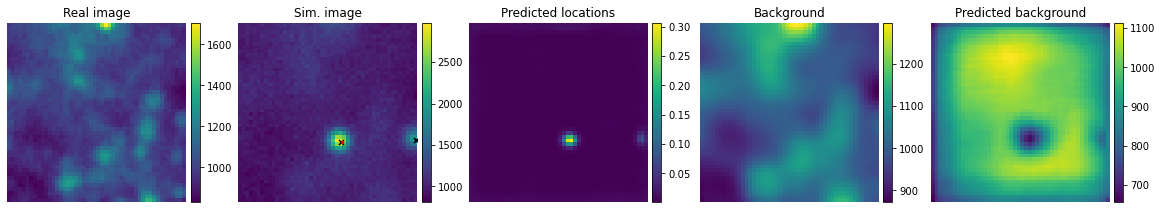

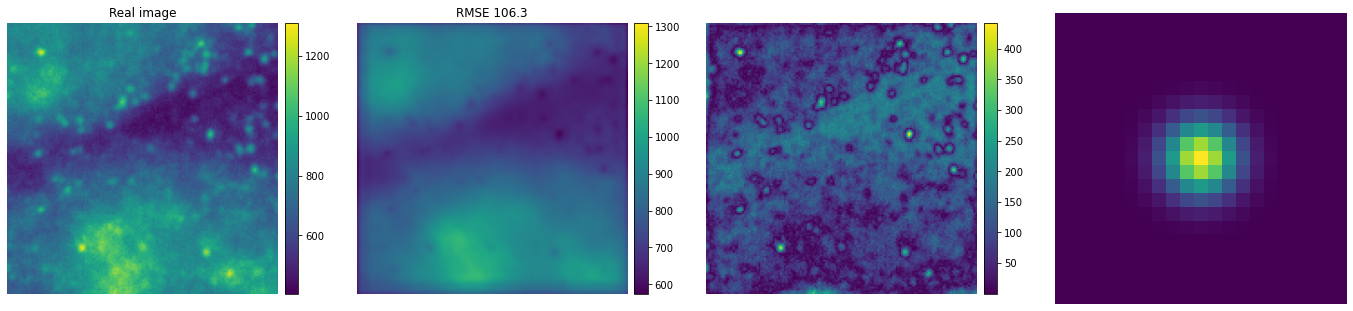

tensor([3.8122, 5.5232, 3.3246, 3.7222, 4.2776, 4.4888, 4.6651, 4.6263, 3.9591,
        4.7577, 3.3246, 3.9626, 3.3858, 4.4067, 3.3514, 3.5565, 4.0161, 3.1500,
        4.2916, 4.4619, 4.1229, 3.5337, 3.3379, 3.5042, 4.2550, 4.0081, 3.9483,
        5.0841, 4.4896, 3.9734, 3.5731, 4.5580, 4.8405, 3.4755, 3.5465, 4.4570,
        3.8900, 3.8156, 4.2837, 4.2271, 3.4834, 3.8262, 5.1217, 3.3471, 4.4894,
        3.3957, 3.3635, 4.3178, 5.0090, 3.7728, 3.6364, 3.5319, 5.0265, 4.0679,
        4.1790, 5.4777, 3.1778, 3.7061, 4.1277, 3.9682, 3.8436, 3.7645, 3.7447,
        3.4683, 4.7653, 3.9952, 3.7569, 4.0015, 4.6403, 3.2621, 3.1541, 3.7350,
        4.4219, 4.0278, 3.8307, 3.9748, 4.3780, 4.7483, 3.6682, 3.5911, 3.3854,
        3.5787, 5.1069, 4.6388, 3.3837, 3.2765, 6.1687], device='cuda:0')
tensor([3.4092, 3.7218, 3.2697, 4.6340, 3.4446, 4.1096, 3.3379, 3.9624, 6.1323,
        3.7915, 6.2373, 3.5210, 3.5678, 4.7650, 4.1994, 3.6813, 4.3891, 4.5909,
        4.2113, 4.3580, 3.6515, 3.3935, 3.7334

wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory


tensor([4.1279, 5.5463, 3.8518, 3.3410, 3.5043, 3.4874, 4.2478, 4.7801, 4.6160,
        3.7194, 4.3631, 3.4566, 3.8603, 3.6070, 4.6873, 4.1964, 4.3170, 5.2756,
        4.8150, 5.2573, 3.8568, 3.8037, 3.5405, 4.2169, 3.8504, 3.3876, 3.2187,
        3.3907, 4.4220, 3.0858, 4.0475, 3.5531, 4.9414, 3.3371, 4.7840, 3.9568,
        5.2209, 4.3993, 3.8058, 3.3763, 3.5649, 4.1305, 3.3614, 3.8321, 3.4281,
        3.6831, 3.1732, 3.8168, 3.5004, 5.3601, 3.9868, 3.7554, 3.7909, 3.4810,
        4.0931, 4.1156, 3.7341, 4.0008, 3.9404, 3.8580, 3.9226, 3.5088, 4.5033],
       device='cuda:0')
tensor([3.8271, 4.0511, 3.3979, 4.0077, 3.7206, 4.8263, 3.6226, 4.6557, 4.3457,
        3.5244, 4.3824, 4.4016, 5.3919, 4.2288, 4.9247, 3.4678, 3.2968, 4.6095,
        3.5553, 3.6375, 3.5623, 3.4188, 3.9337, 3.9423, 3.1038, 3.6977, 4.4156,
        4.3651, 3.7868, 3.8799, 3.5159, 4.2693, 3.2802, 3.3249, 3.1743, 3.7291,
        4.2963, 3.2982, 5.5549, 3.9132, 4.7873, 4.6506, 3.4755, 4.0423],
       device='cuda:0'

tensor([3.4356, 3.5269, 3.0526, 4.5244, 3.5980, 3.6441, 3.4076, 3.7743, 3.4728,
        3.7628, 3.4221, 4.0839, 4.0716, 3.5312, 4.6102, 4.0730, 3.8163, 3.1044,
        4.5044, 4.6677, 3.7738, 3.4066, 4.4151, 5.2906, 3.4697, 3.6824, 4.1076,
        4.3282, 3.9938, 5.0180, 3.8186, 4.3789, 3.7131, 3.4122, 4.0492, 3.4586,
        5.2946, 3.3187, 3.7683, 4.7609, 4.3230, 3.2302, 4.7000, 4.1396, 3.3507,
        5.2937, 4.0139, 4.1014, 3.7585, 3.3614, 3.7032, 4.4484, 3.6433, 3.6667,
        3.8762, 3.6374, 3.5819, 3.6649, 3.6312, 3.2319, 3.4951, 4.0640, 4.4448,
        3.7753, 4.1192, 3.8725, 4.6058, 3.9461, 4.1325, 3.8308, 3.8890, 4.1179,
        4.7154, 3.3296, 3.8961, 4.8069, 4.5999, 3.9564, 5.2302, 4.6266, 3.2913,
        4.1207, 3.9816], device='cuda:0')
tensor([4.0122, 5.2463, 3.4227, 3.5869, 4.3822, 4.0641, 3.8578, 3.3142, 4.0816,
        4.3288, 4.7363, 3.7314, 3.5860, 3.5276, 3.5881, 4.5330, 3.8620, 5.1585,
        3.4186, 4.1804, 4.9262, 4.7436, 4.0836, 5.6656, 3.8745, 4.6934, 4.9501

tensor([3.6603, 4.4657, 3.9286, 3.8003, 3.6647, 3.4162, 3.5257, 5.0451, 4.5576,
        3.6462, 3.7711, 3.1983, 3.4718, 4.6199, 3.3199, 3.5588, 3.1066, 3.4330,
        3.2648, 4.8238, 3.6394, 4.4789, 3.1396, 4.5231, 3.8432, 4.7845, 5.1780,
        4.4703, 3.1239, 3.8525, 3.2241, 4.5874, 3.3967, 3.7236, 4.6706, 3.6341,
        3.8381, 3.4264, 3.3927, 3.4125, 3.8875, 4.6405, 3.5260, 3.5215, 3.6633,
        3.8135, 3.9977, 3.8532, 3.9333, 3.6103, 3.5598, 3.6911, 3.5160, 3.9005,
        4.1908, 3.7596, 5.9768, 4.3721, 4.3097, 3.3898, 4.1629, 3.3538, 3.5227,
        3.1221, 3.4887, 3.8839, 4.1517, 3.9674, 3.6939, 3.7249, 4.2446, 3.9514,
        3.9609], device='cuda:0')
tensor([3.9269, 4.1603, 3.7670, 3.8382, 3.2840, 4.9153, 4.3582, 4.1162, 3.8853,
        3.4618, 4.2360, 3.3828, 3.7024, 3.6224, 5.2901, 3.7440, 3.7831, 3.9293,
        5.0922, 4.9963, 3.3550, 4.0200, 4.3625, 4.3576, 3.9016, 3.1512, 3.9280,
        4.4767, 3.6577, 3.7791, 3.5461, 3.6708, 3.3857, 3.2548, 4.6147, 4.8444,
      

tensor([5.3655, 3.4183, 5.5888, 4.2062, 3.9892, 3.4935, 4.0536, 3.9146, 3.9353,
        4.5178, 3.3893, 3.3641, 4.2391, 4.6154, 3.7759, 4.4652, 3.7633, 3.6139,
        3.6221, 4.6443, 5.0300, 5.2446, 4.9489, 3.2364, 3.8989, 3.8167, 4.1351,
        3.3142, 3.8259, 4.4982, 5.1529, 3.7024, 3.6304, 3.9785, 3.8033, 4.5086,
        4.7423, 3.3868, 5.3241, 3.5848, 3.7378, 4.2009, 3.3326, 3.4267, 3.7014,
        3.2979, 4.1156, 3.9124, 3.3317, 3.7628, 3.8314, 3.9684, 3.6690, 3.2260,
        3.5850, 3.5556, 3.5665, 3.4655, 3.8030, 3.0672, 4.1078, 4.1027, 3.9467,
        5.3162, 3.9287, 4.2420, 3.4642, 4.2065, 4.1903, 5.2592, 3.9145, 3.2308,
        4.8685], device='cuda:0')
tensor([3.6895, 4.1779, 4.7965, 3.9432, 4.0895, 4.4060, 4.7176, 5.4987, 3.1047,
        3.3586, 3.5887, 3.5635, 3.8756, 3.8520, 3.9010, 3.7288, 3.2699, 3.4184,
        3.7584, 3.3452, 3.8382, 3.6967, 3.4501, 3.9339, 4.1034, 3.6672, 4.2475,
        3.9197, 5.0480, 5.1041, 3.9243, 3.7604, 3.9306, 3.9942, 3.9463, 4.7965,
      

tensor([4.6936, 3.6275, 5.7358, 4.4550, 3.7511, 3.4767, 4.4036, 3.7809, 4.1593,
        5.2001, 3.9057, 5.0912, 4.9879, 3.6029, 3.9412, 5.3607, 3.8682, 3.9108,
        3.8130, 3.7388, 3.8693, 4.0565, 3.7545, 3.4614, 4.0116, 4.0986, 3.5888,
        4.1639, 4.7494, 4.7963, 4.6556, 4.2472, 5.0692, 3.9700, 3.7294, 3.7138,
        4.6746, 5.8815, 3.2372, 4.1927, 5.3640, 3.9028, 3.9651, 3.9225, 3.5606,
        4.1346, 3.9519, 3.6286, 4.3779, 4.1436, 4.5283, 4.1954, 4.6735, 3.9997,
        4.2928, 4.7590, 4.0803, 4.5151, 4.4463, 5.6011, 3.6351, 6.8783, 4.5818,
        3.3639, 4.1585, 3.7790, 3.4147, 4.6340, 3.9182], device='cuda:0')
tensor([6.2847, 4.4962, 4.0931, 3.5751, 4.2350, 4.0597, 4.7208, 4.6689, 3.3215,
        3.3996, 3.8189, 3.7000], device='cuda:0')
tensor([3.6933, 4.0343, 4.7495, 3.5649, 5.7020, 4.0128, 3.9576, 3.5121, 3.3261,
        3.6420, 5.3364, 4.7525, 3.8173, 4.8874, 4.0201, 3.8928, 4.0595, 4.8821,
        3.7077, 3.9739, 4.0190, 3.5500, 4.5383], device='cuda:0')
tensor([4.

tensor([4.5101, 3.9604, 4.3247, 3.6118, 3.5579, 3.2463, 3.6481, 3.5676, 4.1364,
        3.4938, 5.1828, 3.1018, 4.0614, 4.7938, 4.0949, 3.9899, 4.3705, 4.3019,
        5.0338, 3.6450, 3.9533, 4.3899, 3.5665, 3.6600, 3.7706, 3.1673, 4.3184,
        4.0482, 5.1584, 4.8959, 3.7211, 4.5537, 4.1688, 4.5235, 4.2923, 3.6405,
        3.2477, 4.7856, 4.3335, 4.0937, 3.3767, 3.0980, 4.4746, 4.0557, 4.0570,
        3.8636, 4.0611, 3.5791, 5.6826, 5.6895, 3.7254, 3.7637, 3.5705, 3.8107,
        4.9193, 3.3579, 3.5768, 4.3982, 3.9318, 3.6556, 3.4979, 4.1176, 4.2761,
        4.4234, 3.3064, 4.5237, 3.6792, 6.0230, 3.4134], device='cuda:0')
tensor([4.3386, 4.1624, 4.3143, 3.8990, 4.2011, 4.6421, 3.9238, 3.5729, 3.2668,
        3.9494, 3.5714, 3.3382, 3.7510, 4.1794, 3.5753, 3.4495, 4.9698, 3.7403,
        3.1200, 4.1403, 3.5291, 3.6704, 5.1735, 3.8794, 4.0690, 4.0945, 3.2935,
        4.6187, 3.9088], device='cuda:0')
tensor([3.8973, 3.6471, 3.7036, 3.6047, 5.1320, 4.0109, 4.4560, 3.8788, 3.3066,
    

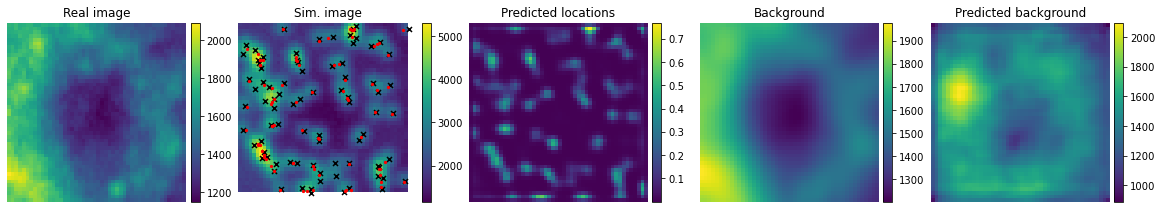

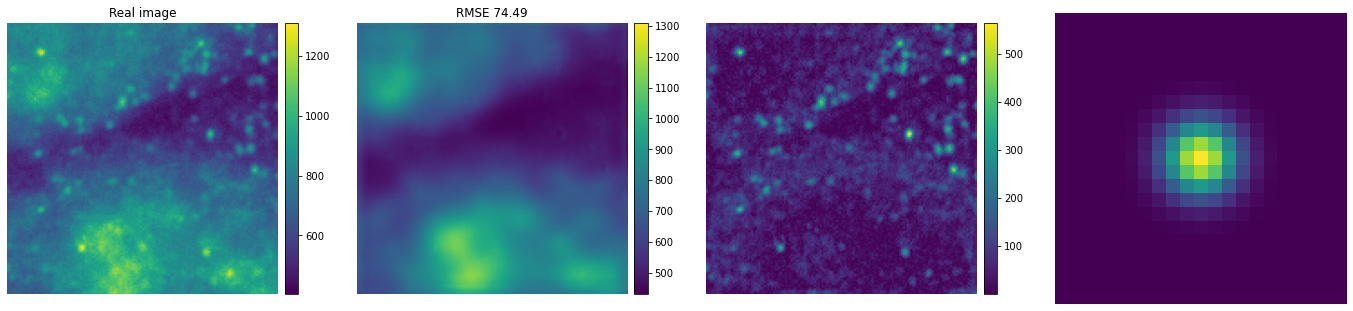

tensor([4.2082, 3.9026, 3.9209, 4.1647, 3.3549, 3.4794, 3.9482, 4.4099, 4.0692,
        4.4041, 4.6681, 3.8624, 3.9956, 3.7125, 3.4988, 4.7102, 4.1171, 4.0342,
        3.2971, 3.5276, 3.5834, 5.2026, 3.4775, 3.8630, 5.2431, 3.6411, 3.4989,
        3.5506, 3.2606, 3.7572, 3.8995, 3.5550, 3.9596, 3.8053, 4.7874, 4.1653,
        4.5728, 3.4366, 3.7190, 3.6044, 4.3987, 3.8972, 4.2913, 3.3926, 3.6725,
        3.6975, 3.5204, 4.0987, 3.7447, 3.8383, 3.5187, 4.1324, 4.1104, 3.7163,
        3.6359, 3.8145, 3.7602, 3.5624, 4.9406, 3.5347, 3.7535, 3.1239, 3.4245,
        3.8621], device='cuda:0')
tensor([3.5747, 4.4762, 3.9176, 4.5028, 3.4662, 3.8261, 3.5362, 3.2039, 4.3153,
        4.3888, 3.6254, 3.9968, 4.9795, 3.9077, 4.5307, 4.0195, 3.9814, 3.2720,
        3.4328, 4.8002, 4.2837, 5.9856, 3.7115, 4.2331, 4.3187, 3.5507, 4.0638,
        3.7993, 3.8607, 3.2814, 4.1983, 4.1360, 3.9136, 3.8427, 4.0572, 3.7342,
        3.6981, 3.8975, 4.4153, 3.5629, 3.3748, 3.2272, 3.5440, 4.0286, 5.5615,
      

wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory


tensor([3.9533, 5.0607, 3.6021, 3.2082, 3.6316, 3.5686, 3.6658, 3.4358, 4.3685,
        3.2415, 4.0833, 3.4233, 3.7551, 5.3747, 3.6599, 4.0275, 3.5001, 3.6787,
        3.9878, 4.4890, 5.3277, 4.9671, 3.9787, 4.8579, 5.2832, 4.1267, 4.0530,
        4.1902, 4.7094, 4.0316, 4.2738, 5.7740, 3.3234, 3.5736, 4.1894, 3.2233,
        3.7950, 5.9256, 3.6057, 4.2118, 4.0109, 3.4318, 3.6580, 3.4117, 3.4715,
        3.8259, 4.1344, 4.6264, 3.9356, 3.3304, 3.9306, 3.6737, 3.9766, 3.7431,
        4.1704, 3.5289, 4.3400, 3.8815, 4.0928, 3.3789, 3.5530, 3.9331, 3.7567,
        3.8868, 3.7023, 3.5312, 3.2090, 4.0637, 3.3775, 3.6839, 5.3787, 4.5576,
        3.6778, 3.8233, 3.5438, 3.8599, 4.9763, 3.8250, 3.1829, 6.5604],
       device='cuda:0')
tensor([4.4245, 4.2333, 3.9506, 4.0577, 4.3932, 3.3144, 4.3059, 4.3135, 3.7751,
        4.4435, 3.2848, 3.5491, 4.8335, 4.0705, 3.8572, 3.7783, 3.9736, 3.3343,
        3.3450, 3.9535, 3.3867, 4.3688, 3.4433, 3.6917, 3.9982, 4.0826, 3.8462,
        4.3199, 4.2375,

tensor([3.5925, 3.4182, 3.8164, 3.9713, 5.3352, 4.3083, 3.5744, 3.7328, 4.1146,
        3.2362, 3.8238, 3.7056, 3.4763, 3.9005, 4.4010, 4.5108, 3.7977, 4.3490,
        3.7623, 3.7001, 3.4949, 4.5889, 4.2577, 4.3412, 3.8995, 4.2371, 3.7298,
        4.1053, 4.2015, 4.4031, 4.5984, 4.1432, 3.8274, 3.9292, 3.8692, 3.7291,
        3.3556, 4.1810, 4.9577, 3.5948, 3.7273, 3.7495, 4.6300, 3.3289, 3.5233,
        3.2381, 3.4954, 4.7392, 4.2772, 3.7792, 3.7647, 3.9344, 3.9717, 4.1886,
        3.4515, 4.1439, 3.7429, 3.7528, 3.3535, 3.5937, 3.8274, 4.4507, 3.8295,
        3.6775, 5.5182, 4.5639, 3.6490, 5.2465, 3.7026, 3.7784, 4.0383, 3.6254,
        6.3644, 4.2670, 5.7295, 3.8249, 3.3690, 3.7481, 3.8619, 3.4365, 4.0571,
        5.1436, 4.9081, 5.1879, 3.7350, 3.1200, 3.9549, 5.3556, 3.5045, 4.0105,
        3.8006, 3.7066, 4.0496, 3.4335, 5.1883, 4.4240, 5.9120, 4.0613, 4.1995,
        4.3330, 3.2802, 4.6632, 4.7509, 3.9467, 4.6184, 4.3073, 3.9309, 4.2798,
        4.3842, 3.9900, 3.6459, 3.3052, 

tensor([3.9626, 3.9408, 3.7018, 3.1161, 3.6127, 4.4994, 3.5107, 4.1714, 3.8719,
        3.8498, 3.9354, 5.2924, 3.7908, 3.7335, 3.3818, 4.1970, 3.6455, 3.4198,
        3.7467, 4.2483, 4.7269, 3.1958, 3.4311, 3.7203, 3.4076, 3.7622, 3.4211,
        5.4739, 3.7163, 3.4211, 3.8003, 3.1672, 5.8804, 3.2555, 5.2716, 3.7153,
        3.7428, 4.5021, 3.9483, 4.1570, 3.7934, 4.6117], device='cuda:0')
tensor([3.7275, 4.1461, 4.9091, 3.4707, 4.1900, 3.4903, 3.3358, 4.3477, 3.8052,
        3.3175, 3.5184, 3.6756, 3.6905, 3.6489, 4.1949, 3.8800, 5.9126, 3.5560,
        3.2088, 4.6228, 3.4457, 3.6377, 3.8969, 4.6083, 3.7532, 4.2124, 3.9491,
        4.0509, 3.7341, 3.7072, 3.6887, 3.4675, 4.0396, 3.9980, 4.0795, 3.9488,
        3.5783, 3.9665, 4.5220, 4.1310, 4.4099, 4.0550, 3.9770, 4.6207, 4.4737,
        4.2791, 3.5653, 3.3915, 3.8733, 4.0754, 3.7811, 3.8183, 4.3512, 3.2713,
        3.1820, 5.1708, 3.3657, 3.6407, 4.0415], device='cuda:0')
tensor([4.0092, 3.8362, 4.0215, 4.6130, 4.1153, 3.8014, 4.89

tensor([4.1725, 3.4096, 3.4735, 3.4190, 4.2014, 4.6208, 3.9626, 3.5525, 4.1620,
        3.8278, 3.3695, 4.5356, 5.0092, 4.4645, 4.4602, 3.2546, 3.5317, 3.9468,
        3.3144, 4.1456, 4.5592, 3.7858, 4.5993, 3.8863, 3.3238, 3.1415, 3.6048,
        4.6169, 3.4234, 3.2480, 3.3820, 3.8950, 4.6009, 4.5342, 3.7083, 3.9660,
        4.1781, 4.2728, 4.9933, 4.5682, 3.3924, 4.2892, 3.8343, 3.6100, 3.7082,
        3.5789, 4.4731, 3.7519, 4.9332, 3.9714, 4.4766, 4.9599, 3.5484, 4.5655,
        5.3435, 3.6780, 4.2778, 3.4452, 4.3495, 4.1202, 4.3180, 3.3263, 4.1615,
        3.6376, 3.3568, 4.3391, 4.2178, 3.7173, 3.4241, 5.0506, 3.7027, 4.4136,
        3.7292, 4.0178, 4.1067, 4.0801, 4.7351, 4.1444, 3.6808, 4.3193, 3.6632,
        3.2474, 4.1646, 3.9703, 3.8368, 4.5884, 4.2691, 5.2457, 3.4583, 4.6462],
       device='cuda:0')
tensor([3.6485, 3.1762, 3.3564, 3.8820, 3.9543, 3.9155, 3.7606, 3.8862, 4.3790,
        3.2853, 3.8060, 4.3667, 5.1351, 4.5808, 4.0512, 4.2696, 3.5273, 3.6872,
        3.7619,

tensor([4.0386, 3.9880, 3.0663, 3.8828, 4.5642, 3.4581, 3.3588, 4.0716, 4.6386,
        3.5255, 4.1433, 4.7933, 3.8836, 3.6024, 4.1267, 4.1036, 4.8721, 3.5999,
        3.9526, 4.4081, 3.6811, 4.6476, 3.5818, 3.7334, 4.5468, 3.9087],
       device='cuda:0')
tensor([4.0568, 4.1264, 3.2667, 4.0210, 4.3998, 3.7822, 4.1744, 3.8984, 4.4939,
        3.3914, 4.2905, 4.2194, 3.6009, 3.8869, 3.3831, 3.4241, 4.3015, 3.4675,
        4.4744, 4.3830, 4.2364, 4.1109, 3.8994, 3.9389, 3.5558, 4.4052, 3.6056,
        3.9702, 3.3381, 3.1671, 3.7286, 3.3864, 4.5675, 4.0908, 3.5476, 3.7466,
        6.1615, 3.4622, 5.6224, 4.0106, 3.7119, 5.1359, 3.4853, 4.2672, 3.4236,
        3.6994, 4.0393, 4.9444, 3.7540, 3.7899, 3.1760, 5.3762, 5.3189, 4.1013,
        4.3933, 3.8571, 4.0368, 3.3890, 4.7251, 6.2517, 4.6920, 5.4219, 3.8737,
        3.6440, 3.5781, 3.6718, 3.5107, 3.5262, 4.3557, 3.7654, 4.8577, 3.5994,
        3.5290, 3.6200, 5.0031, 3.6733, 3.8437, 3.9910, 4.4465, 3.8855, 4.5593,
        4.7666, 3.4499,

tensor([4.3942, 3.8929, 3.4268, 3.6386, 4.4631, 3.8683, 3.4466, 3.3812, 3.6950,
        3.3720, 4.0504], device='cuda:0')
tensor([4.5250, 4.9050, 3.4564, 4.6335, 4.5420, 3.7949, 4.8607, 4.1224, 3.1720,
        3.9411, 4.3535, 3.4999, 3.5939, 3.6333, 3.8265, 3.7404, 3.5301, 3.4740,
        4.1159, 4.6406, 3.5377, 3.8283, 3.5878, 4.1036, 4.1085, 3.4664, 3.9048,
        5.0453, 3.6751, 3.2038, 3.5496, 4.2466, 3.3698, 4.6684, 3.4365, 3.0409,
        3.7754, 4.7699, 3.4605, 3.2868, 3.6234, 4.9516, 3.3796, 3.6255],
       device='cuda:0')
tensor([4.3670, 5.0244, 3.8471, 3.9021, 4.2809, 3.7708, 3.9266, 3.3650, 3.4660,
        5.4941, 3.8559, 3.3878, 3.2987, 4.3059, 3.3688, 3.7478, 4.1918, 3.2982,
        3.9002, 4.4718, 3.8852, 3.1840, 4.5371, 4.7854, 3.5727, 3.8267, 3.5102,
        4.3309, 3.4462, 4.5940, 4.6668, 4.1924, 4.7550, 3.8433, 3.9349, 3.7850,
        5.7907, 4.1267, 3.3813, 3.9758, 3.7299, 4.1606, 4.2374, 3.6957, 4.5787,
        3.4287, 3.6807, 3.6917, 4.7310, 3.3094, 4.2753, 4.213

tensor([4.2551, 4.3317, 4.2288, 3.7702, 5.2438, 4.3020, 3.9934, 3.2041, 3.1774,
        3.6942, 3.4367, 3.1548, 4.1136, 4.7220, 4.2177, 3.7483, 4.4710, 3.4631,
        3.4452, 3.9277, 4.4954, 3.4082, 5.4177, 3.6093, 3.8502, 3.7727, 4.9526,
        3.6783, 3.7972, 5.2174, 3.4199, 3.6810, 4.0415, 3.6370, 3.6107, 5.9711,
        3.9327, 4.0049, 3.9537, 3.3561, 3.8617, 4.7012, 3.8453, 3.6215, 3.5623,
        5.4728, 4.0927, 4.0543, 4.1160, 3.6803, 3.7095, 4.1357, 4.5201, 3.6939,
        3.7680, 3.6077, 3.8451, 4.4516, 4.7942, 3.3207, 3.7875, 3.9881, 3.6629,
        3.4947, 3.4379, 4.1201], device='cuda:0')
tensor([3.2566, 4.5337, 4.2091, 4.5132, 3.8658, 4.1387, 3.8906, 3.8564, 4.5193,
        3.5180, 4.3529, 3.6143, 3.4645, 3.8032, 4.1788, 4.1524, 3.8303, 3.6067,
        3.6139, 3.2833, 5.6375, 4.7067, 3.3248, 3.7080], device='cuda:0')
tensor([3.2298, 4.4003, 3.8117, 3.9371, 3.9508, 3.8074, 4.1619, 3.6901, 4.7112,
        3.8755, 3.2717, 4.2915, 3.7176, 4.2288, 4.6285, 5.0260, 4.1848, 3.16

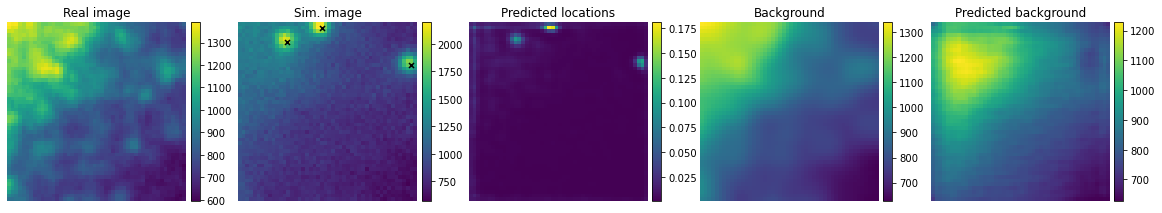

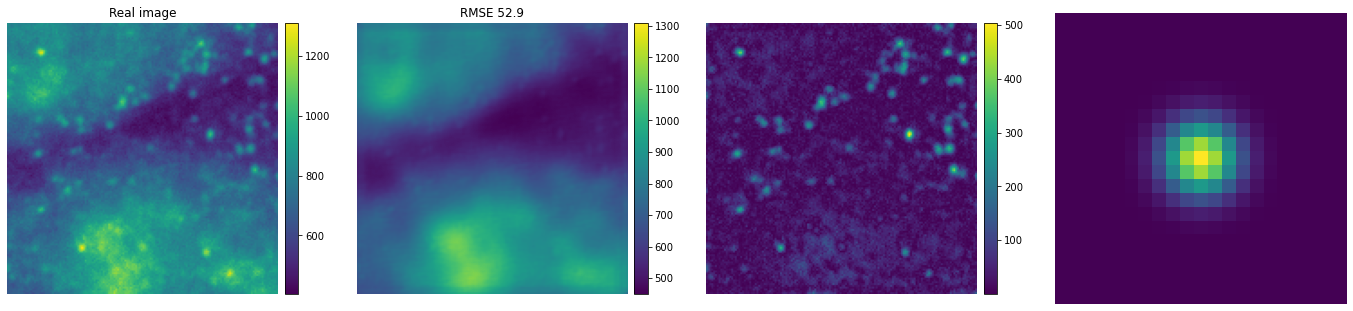

tensor([4.8505, 5.0159, 3.8808, 3.3506, 5.2815, 4.1157, 3.5317, 3.7018, 3.5095,
        3.7671, 3.2086, 4.2104, 3.6873, 3.6961, 4.5778, 4.1252, 4.6523, 4.6978,
        3.5367, 4.7263, 4.1054, 3.4141, 3.2309, 4.6923, 3.2680, 3.5078, 3.4831,
        3.3869, 4.2000, 3.6989, 4.6430, 3.4736, 3.3887, 3.4794, 4.2001, 3.5341,
        3.6028, 3.7837, 4.7586, 3.1934, 3.3642, 3.5933, 4.0589, 5.0869, 3.9819,
        4.1653, 5.8659, 5.4108], device='cuda:0')
tensor([4.1937, 5.6766, 3.3246, 5.2429, 3.9461, 3.4294, 3.6872, 3.3522, 3.6231,
        4.9704, 3.6671, 4.6803, 3.7637, 4.0277, 4.1705, 4.1706, 3.6103, 3.5952,
        3.4112, 4.3540, 4.0883, 4.5461, 3.8960, 3.3862, 3.2395, 4.7387, 5.3399,
        6.3375, 3.9274, 5.5393, 4.1876, 3.6943, 3.6668, 3.6626, 4.2506, 4.1642,
        4.4609, 3.9546, 3.3793, 3.6928, 3.7732, 3.6815, 5.1618, 5.1726, 3.8421,
        4.3500, 3.5164, 4.3809, 3.3139, 3.7661, 4.2779, 3.9665, 4.1098, 3.8300,
        4.1439, 3.6294, 5.1639, 4.0115, 3.6021, 3.5815, 3.3374, 3.6897

wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//decode_fish/runsb/wandb/ wasn't writable, using system temp directory


tensor([3.5417, 4.7178, 4.7309, 4.2318, 3.5517, 3.2273, 3.8516, 4.3173, 3.7755,
        4.2759, 3.9153, 3.3576, 3.4569, 3.9318, 3.3406, 3.4334, 4.0923, 3.4183,
        4.7118, 3.5248, 4.7046, 3.6012, 3.6151, 3.7098, 3.2487, 3.8266, 3.5817,
        4.5102, 3.6139, 3.4509, 4.4523, 4.9591, 4.9333, 3.6636, 3.1261, 3.9923,
        4.7368, 3.4417, 4.0426, 3.9408, 3.3831, 4.6055, 3.7442, 5.0157],
       device='cuda:0')
tensor([3.3077, 3.9331, 3.9841, 3.5974, 3.8860, 3.3229, 3.5002, 3.2914, 3.4264,
        4.1056, 3.1853, 3.7560, 3.8615, 4.4000, 3.9321, 4.1936, 4.2277, 3.7725,
        3.9370, 3.4940, 3.2641, 4.4989, 3.9201, 5.4706, 3.9498, 4.1662, 3.4727,
        3.9250, 3.2578, 4.3617, 3.8049, 3.8520, 4.0016, 3.4430, 3.8133, 4.1044],
       device='cuda:0')
tensor([3.7224, 3.2901, 3.7251, 4.7157, 4.0377, 3.1883, 3.9814, 4.1748, 4.0512,
        3.6709, 4.0410, 4.0263, 3.5303], device='cuda:0')
tensor([3.7982, 4.8194, 3.8932, 4.3141, 4.1752, 4.3064, 4.2177, 4.2199, 3.5854,
        4.2072, 5.80

tensor([3.8375, 3.5091, 4.0059, 3.3461, 3.6555, 3.7870, 3.5168, 4.4264, 3.3541,
        3.4606, 3.3889, 5.1226, 3.9457, 3.8251, 3.3688, 4.6571, 3.9811, 3.5615,
        4.3436, 4.4652, 3.9574, 3.9260, 3.7687, 4.2005, 3.6774, 3.7910, 3.2076,
        3.6508, 5.2855, 3.3745, 3.6199, 4.9410, 3.9937, 4.9716, 3.2806, 3.5831,
        4.2824, 3.1657, 3.1761, 3.4814, 3.4235, 3.5753, 3.1365, 4.1541, 5.9376,
        3.8315, 4.1694, 3.7912, 5.0046, 4.0101, 3.2155, 3.5756],
       device='cuda:0')
tensor([3.6194, 3.7510, 3.3215, 3.3097, 3.2021, 5.2416, 4.1626, 3.5120, 3.8992,
        4.4631, 3.6672, 3.4643, 4.3246, 3.4863, 3.2422, 3.2007, 3.7554, 3.8153,
        3.8344, 3.6849, 5.3807, 3.6105, 4.4423, 4.4866, 4.3122, 3.8872, 3.5251,
        3.9406, 4.2018, 5.0274, 4.5696, 3.9084, 3.6820, 4.6160, 4.6825, 3.4259,
        4.9710, 3.4209, 3.8244, 3.8862, 4.0234, 3.6655, 3.7912, 3.7369, 4.9365,
        4.4626, 3.5081, 3.8174, 3.6511, 3.4985, 3.5018, 4.0753, 3.9059, 3.5468,
        4.0631, 4.1297, 3.9349,

tensor([3.8346, 3.9456, 4.7388, 5.4048, 4.1448, 3.7671, 4.3652, 3.4862, 5.1150,
        3.9074, 3.8602, 3.3603, 3.3407, 3.5708, 3.6829, 3.5374, 3.8201, 3.6093,
        3.8438, 4.1143, 4.8196, 3.8111, 3.6170, 3.6994, 3.4487, 3.7329, 4.0578,
        3.8056, 3.9136, 3.9727, 3.1598, 3.3353, 3.4724, 3.9989, 3.6825, 4.3792,
        3.4633, 3.9342, 5.9325, 3.3398, 3.7044, 3.9448, 4.0093, 5.1516, 3.4466,
        3.7392, 3.8993, 4.4740, 5.1248, 3.8392, 4.9205, 3.7640, 5.4055, 4.2179,
        3.4195, 4.7359, 3.9143, 3.3928, 3.7571, 3.6527, 5.2179, 3.5826, 5.1689,
        3.7338, 3.8146, 4.4680, 5.3660, 4.4289, 4.1555, 3.8516, 4.2202, 3.9235,
        4.2392, 3.6164, 3.0920, 4.4593, 4.8305, 3.5496, 4.9949, 3.1445, 3.5070,
        5.4632, 5.5272, 4.3690, 3.6688, 3.6647, 4.5350, 6.3974, 3.8720],
       device='cuda:0')
tensor([3.0469, 3.6144, 3.8328, 3.5609, 3.5565, 3.7049, 3.7402, 3.5414, 4.0482,
        4.9091, 3.7408, 3.9301, 4.1353, 3.7558, 4.8312, 3.3427, 3.0921, 4.1229,
        3.5421, 4.2163,

tensor([4.1973, 5.3676, 5.2181, 3.2237, 4.2028, 3.9150, 3.2396, 5.6879, 4.6240,
        3.4855, 4.2648, 3.9942, 3.5699, 4.4428, 3.9404, 3.7483, 4.5580, 4.5152,
        4.1046, 3.6378, 4.6168, 3.6932, 3.5213, 4.0684, 3.5756, 4.0353, 3.2817,
        3.4251, 4.0034, 3.3902, 4.6969, 3.4495, 4.7967, 3.5922, 4.2709, 3.4074,
        3.2142, 3.5830, 3.9802, 3.6608, 3.8874, 3.6719, 4.2090, 5.3289, 4.4143,
        3.5377, 3.2951, 5.9027, 4.3792, 3.8758, 3.3891, 3.9828, 3.9701, 3.5684,
        3.2339, 4.1058, 3.9096, 3.5300, 3.4059, 4.4123, 3.8770, 4.4421, 4.1763,
        4.3445, 4.4417, 5.0279, 4.0253, 3.3916], device='cuda:0')
tensor([3.3104, 3.8638, 3.5373, 4.3357, 3.3068, 4.4521, 5.2536, 3.4581, 3.3491,
        3.5101, 3.9291, 3.4134, 4.7098, 4.2760, 3.7203, 5.8137, 4.1746, 3.4420,
        4.5126, 3.2128, 4.3233, 4.3926, 5.1814, 3.5025, 4.2596, 4.0675, 4.4127,
        3.3439, 4.5425, 3.2475, 3.8401, 4.0795, 3.2353, 3.1917, 4.2876, 3.2417,
        4.0121, 3.8637, 3.6737, 3.4602, 4.1189, 4.6950

tensor([3.8269, 5.2126, 4.3491, 3.9179, 4.0449, 5.7749, 3.7653, 3.3969, 4.5422,
        3.9388, 3.3788, 3.4998, 4.6995, 3.9143, 4.4008], device='cuda:0')
tensor([3.6253, 4.1640, 3.7235, 3.7922, 3.6037, 4.1107, 3.2011, 3.6662, 3.3290,
        3.8520, 3.9755, 3.8793, 3.4615, 3.5476, 3.5261, 3.9971, 5.0428, 4.1657,
        3.2383, 4.5821, 3.9037, 4.8706, 4.5310, 4.8954, 3.3300, 3.7604, 3.6826,
        4.0556, 4.1505, 4.4162, 3.6183], device='cuda:0')
tensor([3.2809, 3.7967, 3.5990, 3.7515, 3.8959, 3.7593, 4.2491, 3.5967, 4.9373,
        3.6435, 3.7755, 4.1759, 3.6855, 3.5529, 3.5889, 4.8435, 3.8664, 5.3076,
        4.1441, 4.5137, 4.1926, 4.9805, 3.7602, 6.2529, 3.5128, 3.2629, 4.0523,
        3.1968, 3.8308, 3.4174, 5.2138, 3.8661, 3.5775, 4.0009, 3.6426, 4.8329,
        3.4856, 3.6370, 5.0503, 3.1833, 3.3626, 4.3683, 3.7744, 3.7755, 3.6636,
        3.5160, 4.7169, 4.5091, 3.8722, 3.6980, 3.7168, 3.6314, 3.7117, 3.6048,
        4.7226, 3.7790, 4.4074, 4.0210, 4.5597, 3.6946, 3.5306, 4.03

tensor([3.5919, 3.2849, 3.5935, 4.7741, 4.9687, 4.0867, 3.3056, 4.1265, 4.1746,
        3.9554, 3.6272, 3.5400, 3.8245, 3.7638, 4.0957, 3.6165, 4.3117, 3.3919,
        4.7893, 3.4960, 4.5140, 4.2070, 3.8324, 4.0861, 3.6804, 4.4165, 3.5754,
        3.7294, 4.4407, 3.8477, 4.1035, 4.5749, 3.8195, 4.0319, 3.6508, 3.0791,
        3.3317, 5.2014, 3.4857, 4.3199, 3.6504, 4.9853, 3.9122, 3.5251, 4.2099,
        4.3817, 4.2940, 4.6932, 3.2376, 3.9117, 3.6434, 3.9942, 3.5175, 3.1133,
        3.9261, 5.3704, 4.2783, 3.9786, 3.6255, 3.1909, 5.8257, 4.5911, 4.0447,
        3.6176, 3.7704, 4.1650, 3.9618, 3.4748, 3.4687, 3.4941, 3.9596, 3.2669,
        4.6310, 3.6627, 4.1071, 4.9167, 4.5867, 3.3904, 4.3481, 3.8329, 4.9514,
        4.7871, 4.2571, 3.6664, 3.6384, 4.0795, 3.9709, 3.2350, 5.1367, 3.8199,
        4.3269, 4.1968, 4.4474, 4.2790, 5.1383, 3.8819, 3.5082, 4.3569, 3.8924,
        3.6527, 4.4337, 4.4495, 3.2609, 4.0601, 3.4321, 4.3576],
       device='cuda:0')
tensor([3.9179, 4.1836, 3.8165,

tensor([4.5097, 6.4720, 4.1353, 4.0641, 3.8691, 4.4724, 3.9726, 3.9584, 4.7905,
        4.1372, 4.5644, 4.3526, 4.9712, 3.8146, 4.5430, 3.8701, 4.0942, 3.8129,
        4.9620, 4.1118, 4.5410, 3.7081, 3.6268, 4.0189, 3.8070, 4.3358, 4.4836,
        3.3393, 3.5741, 4.8334, 3.8746, 4.1820, 4.0009, 3.8082, 4.3681, 4.4336,
        3.1485, 3.4251, 3.8212, 3.5288, 6.4068], device='cuda:0')
tensor([3.7255, 3.8345, 3.2212, 4.6217, 3.6268, 3.5271, 4.9975, 3.7323, 4.3935,
        4.0117, 4.4569, 3.9479, 3.6406, 3.8392, 4.7811, 4.5535, 4.6819, 3.6743,
        3.3637, 5.0077, 4.1310, 4.1976, 3.7456, 3.8903, 4.3829, 3.9229, 4.4392,
        4.3701, 5.0398, 4.5294, 3.7924, 3.9146, 5.4639, 3.1263, 3.9988, 3.6919,
        4.6218, 4.3750, 3.5479, 4.0082, 4.3103, 3.7321, 4.2251, 3.5770, 3.2980,
        4.4358, 5.1843, 3.9937, 4.6326, 3.4712, 3.6091, 3.6760, 3.7713, 3.3531,
        3.5036, 3.7442, 3.8595], device='cuda:0')
tensor([3.4405, 4.0004, 3.6399, 3.4980, 3.4028, 4.1202, 3.7118, 3.4158, 3.7922,
    

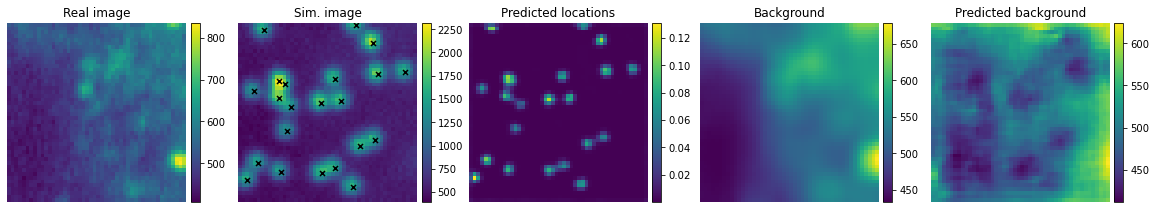

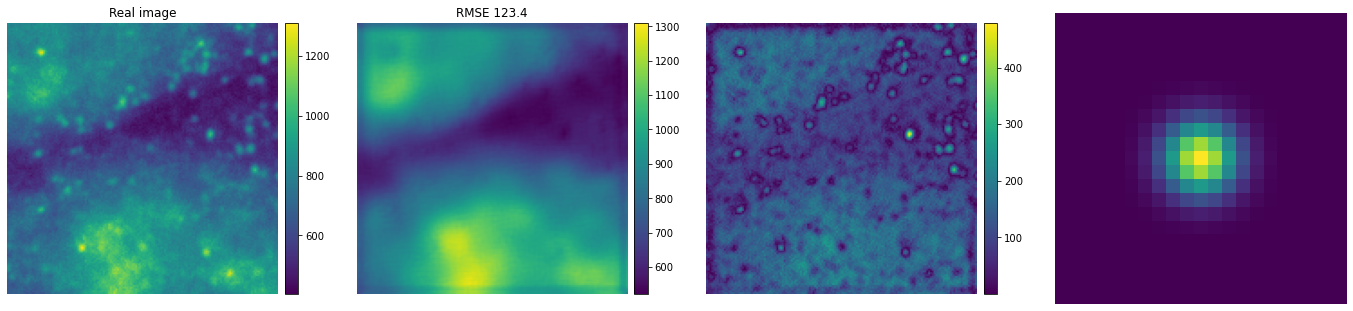

tensor([3.5362, 3.6712, 3.4454, 3.8832, 4.9509, 3.9619, 3.4750, 3.6637, 3.7225,
        3.9351, 6.3601, 3.5082, 3.8638, 3.5420, 3.4676, 3.3337, 3.4905, 3.5229,
        4.0892, 3.8830, 4.0740, 3.5623, 3.6795, 4.8854, 3.5377, 4.0796, 4.4317,
        4.3584, 3.6071, 4.2522, 5.2238, 3.7676, 3.2790, 3.5636, 5.6989, 3.9420,
        3.6475, 4.6238, 4.3550, 4.7741, 3.6827, 3.2862, 3.6684, 4.2275, 3.8020,
        4.7711, 4.6156, 4.3155, 3.0744, 4.3339, 4.2108, 3.2937, 3.8022, 4.2700,
        3.7175, 3.4363, 4.1770, 3.8368, 3.4999, 3.9893, 3.3638, 3.8647, 4.2839,
        4.9615, 3.4177, 5.4147, 3.9500, 5.8409, 3.9818, 3.7108, 3.2174, 3.5826,
        3.8710, 4.9686, 4.2747, 4.0912, 4.0434, 3.8907, 3.8844, 4.2451],
       device='cuda:0')
tensor([4.0674, 4.5430, 4.3343, 3.9294, 4.0011, 4.1459, 5.1086, 4.9453, 3.1727,
        4.1245, 3.9532, 4.9401, 4.2656, 3.7801, 3.2962, 3.5074, 3.3816, 3.4408,
        4.2898, 3.3704, 4.0558, 4.0217, 3.4100, 3.7508, 6.0659, 3.5794, 4.1764,
        5.8627, 3.5137,

KeyboardInterrupt: 

In [ ]:
train(cfg=cfg,
     model=model, 
     microscope=micro, 
     post_proc=post_proc,
     dl=decode_dl, 
     optim_dict=optim_dict, 
     eval_dict=eval_dict)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted index.ipynb.
